## Data Mining

Chan Pei Shan 17198798

Too Ai Leng 17201119

In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import random
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import average_precision_score
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_precision_recall_curve

In [2]:
train_identity = pd.read_csv(f'./data mining/train_identity.csv')
train_transaction = pd.read_csv(f'./data mining/train_transaction.csv')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Exploratory data Analysis

In [4]:
list_num = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11']
list_cat = []
for i in range(12,39):
    a='id_'+str(i)
    list_cat.append(a)
numerical = train.filter(regex='^C|dist|^D[0-9]{1,3}$|^M|^V',axis=1)
numerical[list_num]=train.loc[:,list_num]
categorical = train.filter(regex='^card|^addr|emaildomain|Device',axis=1)
categorical[list_cat]=train.loc[:,list_cat]

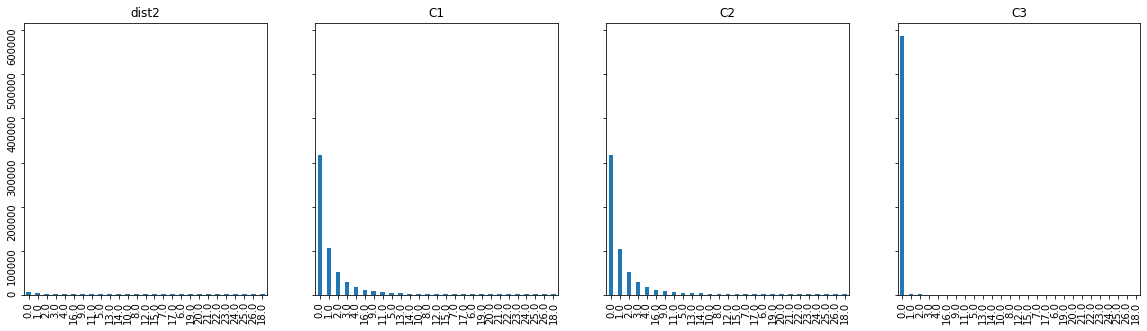

In [5]:
a=[1,2,3,4]
fig, ax = plt.subplots(1, 4,figsize=(20,5),sharex=True, sharey=True)

for i, categorical_feature in enumerate(numerical[numerical.columns[a]]):
    numerical[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
for ax in fig.axes:
    ax.tick_params(labelrotation=90)
fig.show()

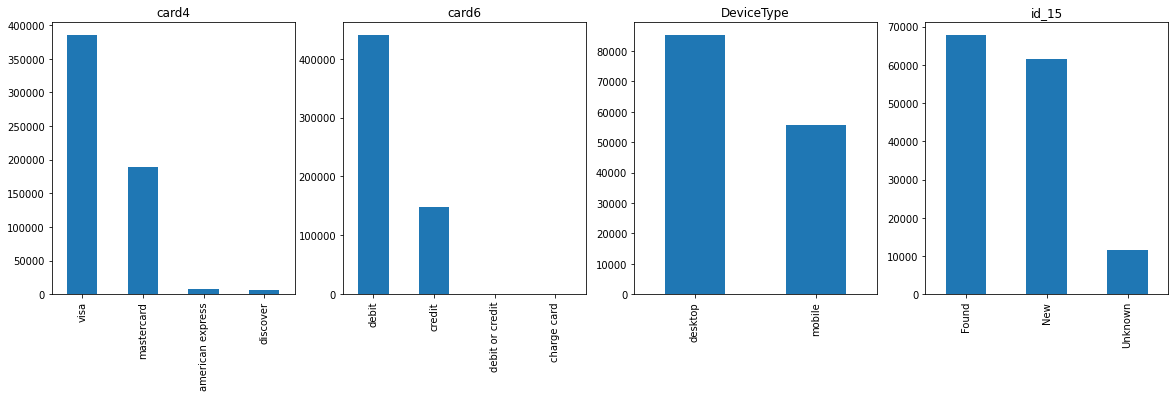

In [6]:
a=[3,5,10,15]
fig, ax = plt.subplots(1, 4,figsize=(20,5))
for i, categorical_feature in enumerate(categorical[categorical.columns[a]]):
    categorical[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
fig.show()

## Feature Engineering

In [7]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')
train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')
train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)

## Prepare data for modelling

1. Data Cleaning - drop columns and rows with too many missing values

In [8]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
cols_to_drop = list(set(many_null_cols  + big_top_value_cols + one_value_cols))
cols_to_drop.remove('isFraud')
train = train.drop(cols_to_drop, axis=1)

def get_too_many_null_attr(data):
    ccols = [x for x in data.columns if data[x].isnull().sum() / data.shape[0] > 0.70]
    return ccols
cl = get_too_many_null_attr(train)
train = train.drop(columns = cl)
train = train.dropna(axis=0, thresh=train.shape[1]*0.9)

In [9]:
train.shape

(255727, 186)

## Data Cleaning 2

- We replaced missing values with -1 in category variables
- category variables are then label encoded.
- Impute numerical smissing values with mode

In [10]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
train = train.replace([np.inf, -np.inf], np.nan)
def clean_nan(df):
    for col in cat_cols:
        return df.replace(['None', np.nan], '-1')  
train = clean_nan(train)
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
from sklearn.impute import SimpleImputer
im = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cols = list(train.columns)
train = pd.DataFrame(im.fit_transform(train.astype('float')), columns=cols)

#### Note  that fraud data and non-fraud data have a very huge difference.

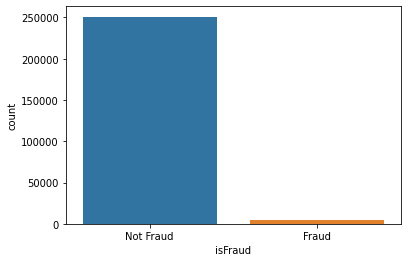

In [11]:
g = sns.countplot(train['isFraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

## Balancing Data
- fraud data: about 4k
- get 4k non-fraud data


In [12]:
df = train
df2 = df.loc[df['isFraud']==0].sample(n=4000,random_state=1234)
df2 = df2.append(df[df['isFraud']==1])

# Dimension Reduction
- Drop by low varience
- Drop by high correlation

<AxesSubplot:>

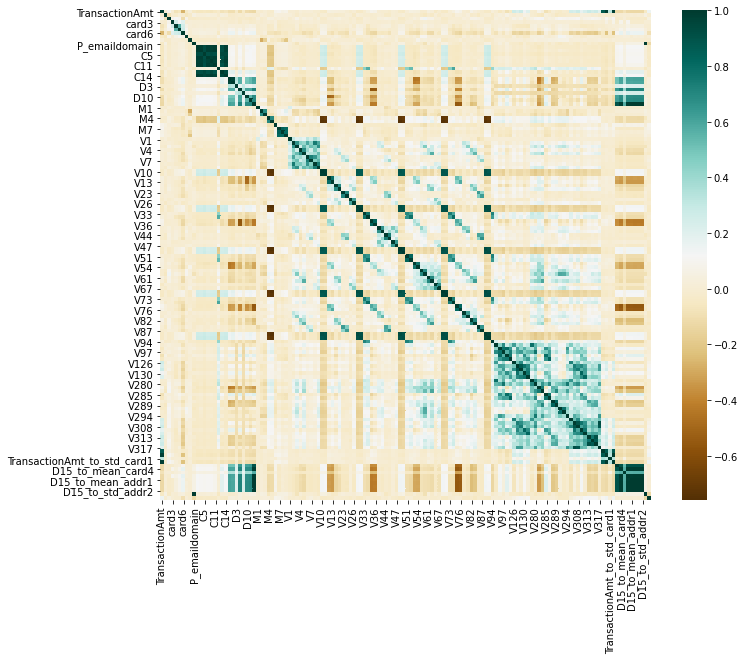

In [13]:
x = df2.drop(['isFraud','TransactionID','TransactionDT'],axis=1)
y = df2.isFraud

# Drop by low varience
varience = x.var().sort_values()
x.drop(list(varience[varience==0].index),axis=1,inplace=True)
# Drop by high correlation
cor_matrix = x.corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(cor_matrix,cmap='BrBG')

In [14]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.4)]
x.drop(to_drop,axis=1,inplace=True)
#Standardize
x_std=StandardScaler().fit_transform(x)

## Split dataset

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2, random_state=1234)

# Feature Extraction
- PCA

In [17]:
#PCA
from sklearn.decomposition import PCA
pca_train = PCA().fit(x_train)
x_values = range(1, pca_train.n_components_+1)

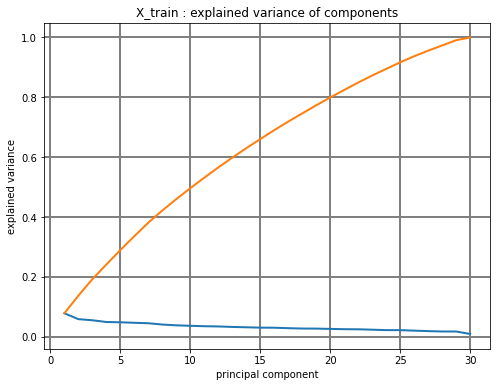

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_values, 
        pca_train.explained_variance_ratio_, 
        lw=2, 
        label='explained variance')
ax.plot(x_values, 
        np.cumsum(pca_train.explained_variance_ratio_), 
        lw=2, 
        label='cumulative explained variance')
ax.grid(color='grey', linestyle='-', linewidth=2)
ax.set_title('X_train : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()
pca = PCA(.95).fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

# Modeling

1. Random Forest

In [19]:
#RandomForest
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
rf_classifier = rf_classifier.fit(x_train, y_train)
rf_pred       = rf_classifier.predict(x_test)
print(confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))
print('randomforest accuracy: '+str(accuracy_score(y_test, rf_pred)))

[[601 200]
 [137 846]]
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       801
         1.0       0.81      0.86      0.83       983

    accuracy                           0.81      1784
   macro avg       0.81      0.81      0.81      1784
weighted avg       0.81      0.81      0.81      1784

randomforest accuracy: 0.8110986547085202


## Linear Regression

In [20]:
#linear regression
log_model = LogisticRegression()
log_model = log_model.fit(x_train, y_train)
log_pred = log_model.predict(x_test)
print(confusion_matrix(y_test,log_pred))
print(classification_report(y_test,log_pred))
print('regression accuracy: '+str(accuracy_score(y_test, log_pred)))

[[480 321]
 [206 777]]
              precision    recall  f1-score   support

         0.0       0.70      0.60      0.65       801
         1.0       0.71      0.79      0.75       983

    accuracy                           0.70      1784
   macro avg       0.70      0.69      0.70      1784
weighted avg       0.70      0.70      0.70      1784

regression accuracy: 0.7045964125560538


## Naive Bayes

In [22]:
#naive bayes
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train, y_train)
nb_pred  = nb_model.predict(x_test)
y_score_nb = nb_model.predict_proba(x_test)[:,-1]
print(confusion_matrix(y_test,nb_pred))
print(classification_report(y_test,nb_pred))
print('naive bayes accuracy: '+str(accuracy_score(y_test, nb_pred)))

[[582 219]
 [364 619]]
              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67       801
         1.0       0.74      0.63      0.68       983

    accuracy                           0.67      1784
   macro avg       0.68      0.68      0.67      1784
weighted avg       0.68      0.67      0.67      1784

naive bayes accuracy: 0.6732062780269058


## Decision Tree

In [23]:
#decision tree
dt_model = DecisionTreeClassifier(random_state=0)
dt_model = dt_model.fit(x_train, y_train)
dt_pred  = dt_model.predict(x_test)
print(confusion_matrix(y_test,dt_pred))
print(classification_report(y_test,dt_pred))
print('decision tree accuracy: '+str(accuracy_score(y_test, dt_pred)))

[[517 284]
 [270 713]]
              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65       801
         1.0       0.72      0.73      0.72       983

    accuracy                           0.69      1784
   macro avg       0.69      0.69      0.69      1784
weighted avg       0.69      0.69      0.69      1784

decision tree accuracy: 0.6894618834080718


## SVM

In [24]:
svm_model = svm.SVC(kernel='linear', probability=True)
svm_model = svm_model.fit(x_train, y_train)
svm_pred  = svm_model.predict(x_test)
print(confusion_matrix(y_test,svm_pred))
print(classification_report(y_test,svm_pred))
print('svm accuracy: '+str(accuracy_score(y_test, svm_pred)))

[[422 379]
 [152 831]]
              precision    recall  f1-score   support

         0.0       0.74      0.53      0.61       801
         1.0       0.69      0.85      0.76       983

    accuracy                           0.70      1784
   macro avg       0.71      0.69      0.69      1784
weighted avg       0.71      0.70      0.69      1784

svm accuracy: 0.702354260089686


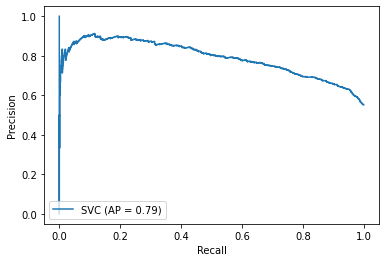

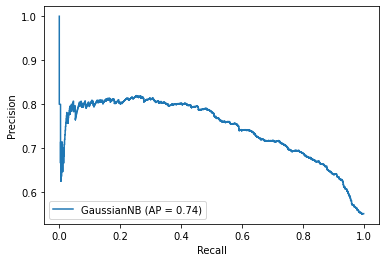

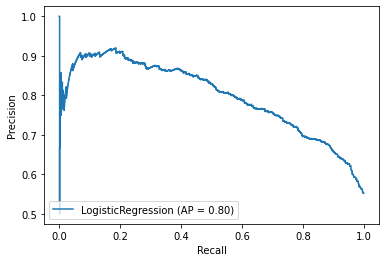

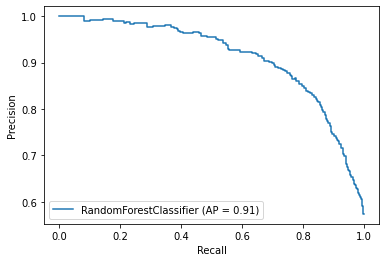

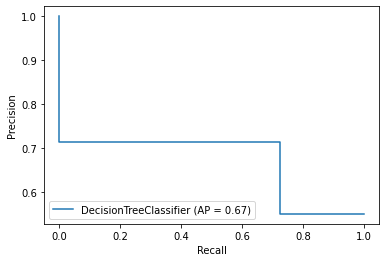

In [25]:
plot_precision_recall_curve(svm_model, x_test, y_test)
plot_precision_recall_curve(nb_model, x_test, y_test)
plot_precision_recall_curve(log_model, x_test, y_test)
plot_precision_recall_curve(rf_classifier, x_test, y_test)
plot_precision_recall_curve(dt_model, x_test, y_test)